<a href="https://colab.research.google.com/github/DanieleFoscarin/HDA2021/blob/main/Remake_ESC50_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fine tuning reference https://www.kaggle.com/sgcuber24/fine-tune-mobilenet-v2

Model choice reference https://towardsdatascience.com/how-to-choose-the-best-keras-pre-trained-model-for-image-classification-b850ca4428d4

In [1]:
# TODO change chromagram with gammatone

# ! pip install git+https://github.com/detly/gammatone.git
# import gammatone

In [2]:
! pip install icecream --quiet
from icecream import ic

In [3]:
from pathlib import Path
from scipy.io import wavfile
from IPython.display import Audio
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
import librosa
from tqdm import tqdm, tqdm_notebook, notebook
import gc
import time 
# import numba
import os


import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import Sequence, SequenceEnqueuer   # try enquerer that uses parallelism
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization

#import model 
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

sr = 44100

In [4]:
! pip install optuna --quiet
import optuna

     |████████████████████████████████| 296kB 11.5MB/s 
     |████████████████████████████████| 81kB 8.5MB/s 
     |████████████████████████████████| 1.2MB 19.0MB/s 
     |████████████████████████████████| 112kB 40.1MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
     |████████████████████████████████| 143kB 39.2MB/s 
     |████████████████████████████████| 81kB 9.8MB/s 


In [5]:
!pip install livelossplot --quiet
from livelossplot import PlotLossesKeras

# Get Dataset

In [6]:
# Clone the entire repo.
!git clone https://github.com/karolpiczak/ESC-50.git


Cloning into 'ESC-50'...
remote: Enumerating objects: 4154, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 4154 (delta 10), reused 0 (delta 0), pack-reused 4136
Receiving objects: 100% (4154/4154), 878.78 MiB | 27.57 MiB/s, done.
Resolving deltas: 100% (257/257), done.
Checking out files: 100% (2011/2011), done.


In [8]:
ROOT = '/content/ESC-50/audio/'

data_info = pd.read_csv(ROOT+"../meta/esc50.csv")

#make a category dictionary
category_dict = dict(zip(data_info['target'], data_info['category']))
# to_onehot_dict = dict(zip(range(0,50), np.))

#remove unused coumn and add other
# aug_col = np.zeros((len(data_info),1))
# mixup_col = -1 * np.ones((len(data_info),1))
# data_info.drop('esc10', axis=1, inplace=True)
# data_info.drop('src_file', axis=1, inplace=True)
# data_info.drop('take', axis=1, inplace=True)

# data_info['augmentation'] = aug_col
# data_info['mixup'] = mixup_col

# # one hot encoding from category
# data_info = pd.get_dummies(data_info, columns=["category"], prefix='', prefix_sep='') 


data_info

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A
...,...,...,...,...,...,...,...
1995,5-263831-B-6.wav,5,6,hen,False,263831,B
1996,5-263902-A-36.wav,5,36,vacuum_cleaner,False,263902,A
1997,5-51149-A-25.wav,5,25,footsteps,False,51149,A
1998,5-61635-A-8.wav,5,8,sheep,False,61635,A


ic| len(audio_loader): 2000


<class 'pandas.core.series.Series'>
washing_machine


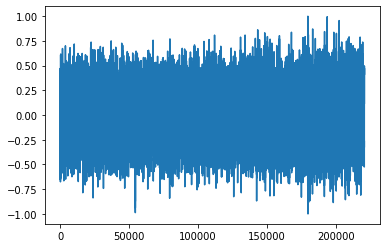

In [9]:
class AudioLoader():
    def __init__(self, df, root, format1=False):
        self.df = df
        self.root = root
        self.format1 = format1

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        _, this_audio = wavfile.read(os.path.join(self.root, self.df['filename'][idx]))
        if self.format1:
            this_audio = this_audio / 32768
        return this_audio

    def get_info(self, idx, list=False):
        if list:
            out = self.df.iloc[idx].to_list()
        else:
            out = self.df.iloc[idx]
        return out


audio_loader = AudioLoader(data_info, ROOT, True)
ic(len(audio_loader))
plt.plot(audio_loader[123])
print(type(audio_loader.get_info(123)))
print(audio_loader.get_info(123)['category'])

# Try first with very basic preprocessing and classification
without kfold or slicing

Save numpy files on disk in and keep using only filenames

Augmentation

In [13]:
# ! mkdir -p mel_storage
# path_mel = "/content/mel_storage/"

# ! mkdir -p mfcc_storage
# path_mfcc = "/content/mfcc_storage/"

# ! mkdir -p chroma_storage
# path_chroma = "/content/chroma_storage/"

# path_list = [path_mel, path_mfcc, path_chroma]

!mkdir -p feature_storage
path_batch = "/content/feature_storage/"

path_drive = '/content/drive/MyDrive/UNI_ICT/HDA/data/' 

# Preprocessing functions

remeber to apply augmentation and mixup only on the training samples, foldwise

## Removing silence

removing silence at the beginning or at the end of the audio clip

In [84]:
def removeSilence(signal, fill_silence=False):
    """
    Remove the leading and trailing zeros in an array,
    Parameters:
        signal: array,
        fill_silence: boolean, if True it repeats the non zero part until the 
            size of the output array is the same as the input array
    Return:
        an array

    """
    
    trimmed = np.trim_zeros(signal)
    if not fill_silence:
        return trimmed
    if fill_silence:
        lt = len(trimmed)
        ls = len(signal)
        # ic(lt,ls)
        if lt < ls:
          trimmed = np.tile(trimmed, int(np.ceil(ls/lt)))
          trimmed = trimmed[:ls]  
        return trimmed

# ic(len(audio_list[0]))
# a = removeSilence(audio_list[0], fill_silence=True)
# librosa.display.waveplot(a, sr=SR)
# ic(len(audio_list[0]))
# ic(len(a))
# # IPython.display.Audio(a, rate=sr)

## Segmentation

In [ ]:
def segmentation(y, seg_len, overlap=0, pad_end='off'):
    """ 
    Returns a list of array with same size, extracted from a signal
    parameters: 
        y: array, input signal
        seg_len: int, number of samples of the output segments
        overlap: int, number of samples overlapped between two segments
        pad_end: 'off': no padding,
                 'half': maximum padding is hald of seg_len,
                 'full': allows for the maximum number of segments. 
    return:
        a list of arrays.
    """
    y_len = len(y)
    # if seg_len > y_len or overlap > seg_len:        
    seg_begin = 0
    seg_end = seg_begin + seg_len
    seg_list = []
    

    if pad_end == 'full':
        pad = np.zeros((seg_len - overlap,))
        print(np.shape(pad))
        y = np.concatenate((y, pad)) 
        while seg_begin < y_len:
            seg_end = seg_begin + seg_len
            seg_list.append(y[seg_begin:seg_end])
            seg_begin = seg_begin + seg_len - overlap

    if pad_end == 'off':
        while seg_end < y_len:
            seg_end = seg_begin + seg_len
            seg_list.append(y[seg_begin:seg_end])
            seg_begin = seg_begin + seg_len - overlap
    
    if pad_end == 'half':
        pad = np.zeros((int(seg_len/2),))
        print(np.shape(pad))
        y = np.concatenate((y, pad)) 
        while seg_begin + seg_len < len(y):
            seg_end = seg_begin + seg_len
            seg_list.append(y[seg_begin:seg_end])
            seg_begin = seg_begin + seg_len - overlap
    #TODO more options on padding

    return seg_list


# out = segmentation(0.5*np.ones((12,)), 5, 0, pad_end='half')
# # print(np.shape(out))
# print(out)
# print(a)


## compute spectral features

In [85]:
def features(audio, sr, bands=64):
    def normalize01(data):
        return (data - np.min(data)) / (np.max(data) - np.min(data))

    this_mel = librosa.amplitude_to_db(librosa.feature.melspectrogram(audio.astype('float32'), sr=sr, hop_length=int(sr*0.01), n_mels=bands ))
    this_mfcc = librosa.feature.mfcc(S=this_mel, sr=sr, n_mfcc=bands)
    this_chroma = librosa.feature.chroma_stft(audio.astype('float32'), sr=sr, hop_length=int(sr*0.01), n_chroma=bands)
    features = [normalize01(this_mel), normalize01(this_mfcc), normalize01(this_chroma)]
    return features

## Mixup

Mixup function
It need one-hot encoding

In [ ]:
# need to understand this

def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


def mix_up(ds_one, ds_two, alpha=0.2):
    # Unpack two datasets
    # TODO adapt here
    images_one, labels_one = ds_one
    images_two, labels_two = ds_two
    batch_size = tf.shape(images_one)[0]

    # Sample lambda and reshape it to do the mixup
    l = sample_beta_distribution(batch_size, 0.2, 0.2)
    x_l = tf.reshape(l, (batch_size, 1, 1, 1))
    y_l = tf.reshape(l, (batch_size, 1))

    # Perform mixup on both images and labels by combining a pair of images/labels
    # (one from each dataset) into one image/label
    images = images_one * x_l + images_two * (1 - x_l)
    labels = labels_one * y_l + labels_two * (1 - y_l)
    return (images, labels)

Three in one feature extraction function

In [86]:
#write doc for those functions

def audio_aug2(y, sr=44100, low_ps=-3.5, high_ps=3.5, low_ts=0.8, high_ts=1):
    '''It return a signal with random pitch shift ot time strecth '''

    choice = int(np.random.randint(2))
    if choice == 0:
        step = np.random.uniform(low=low_ps, high=high_ps)
        ya = librosa.effects.pitch_shift(y, sr=sr, n_steps=step)
    elif choice == 1:
        rate = np.random.uniform(low=low_ts, high=high_ts)
        ya = librosa.effects.time_stretch(y, rate)

    ya = ya[:y.shape[0]]
    return ya

def features_preprocessor(audio_loader, path, df, augmentation=0):
    # mel_names = []
    # mfcc_names = []
    # chroma_names = []
    # data_info_aug = data_info.copy()
    # pd_counter = 0


    if augmentation==0:
        for i in notebook.tqdm(range(len(audio_loader))):
            this_audio = audio_loader[i][:sr*5]
            this_audio = removeSilence(this_audio, fill_silence=True)
            these_features = features(this_audio, sr)
            pack = np.array([these_features, audio_loader.get_info(i)['fold'], audio_loader.get_info(i)['target']], dtype= 'object')
            np.save(os.path.join(path, audio_loader.get_info(i)['filename']+'_0'), pack)

    if augmentation > 0:
        # TODO!!
        for i in notebook.tqdm(range(len(audio_loader))):
            this_audio = audio_loader[i][:sr*5]
            this_audio = removeSilence(this_audio, fill_silence=True)
            for aug in range(augmentation):
                
                if aug == 0:
                    these_features = features(this_audio, sr)
                    pack = np.array([these_features, audio_loader.get_info(i)['fold'], audio_loader.get_info(i)['target']], dtype='object')
                    np.save(os.path.join(path, audio_loader.get_info(i)['filename']+'_0'), pack)
                else:
                    this_audio = audio_aug2(this_audio, sr=sr)
                    these_features = features(this_audio, sr)
                    pack = np.array([these_features, audio_loader.get_info(i)['fold'], audio_loader.get_info(i)['target']], dtype='object')
                    np.save(os.path.join(path, audio_loader.get_info(i)['filename']+'_'+str(aug)), pack)


        

In [93]:
# NB need to do augmentation only in the training files!!!
# TODO save the numpy with 3 features together with its info
# so you can load a file having all the info, and no mismatch errors
# then save everything on drive and load from there

# mel_names, data_info_aug = features_preprocessor(audio_list, path_list, data_info, augmentation=0)
ic(ROOT)
audio_loader = AudioLoader(data_info, ROOT, format1=True)
features_preprocessor(audio_loader, path_drive, data_info, augmentation=5)

ic| ROOT: '/content/ESC-50/audio/'


/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning:

Trying to estimate tuning from empty frequency set.



test with reading feature packs

In [22]:
feat_names  = os.listdir(path_batch)
fold = 2
this_fold_names = [x for x in feat_names if x[0]==str(fold)]



ic| np.shape(this_feat): (554, 64, 3)


pig


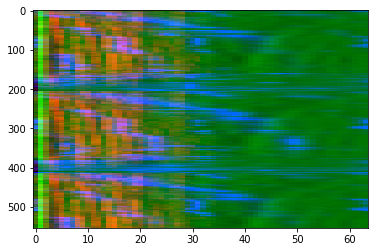

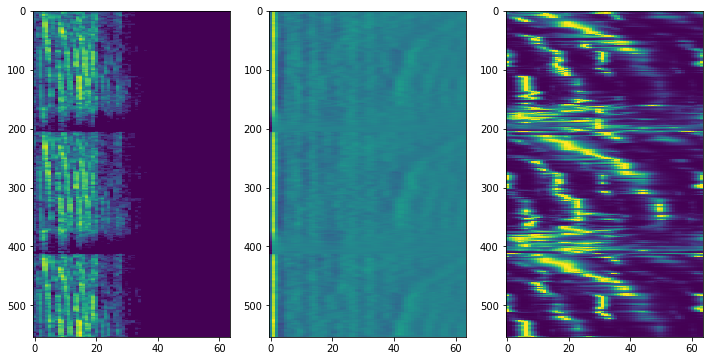

In [38]:
this_pack = np.load(os.path.join(path_batch, this_fold_names[20]), allow_pickle=True)
this_feat = np.transpose(this_pack[0], [2,1,0])
print(category_dict[this_pack[1]])

ic(np.shape(this_feat))
plt.figure()
plt.imshow(this_feat, interpolation='nearest', aspect='auto')

plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.imshow(this_feat[:,:,0], interpolation='nearest', aspect='auto')
plt.subplot(1,3,2)
plt.imshow(this_feat[:,:,1], interpolation='nearest', aspect='auto')
plt.subplot(1,3,3)
plt.imshow(this_feat[:,:,2], interpolation='nearest', aspect='auto')

make Sequence class

In [70]:
class FeatureSequence(Sequence):
    def __init__(self, names, path, batch_size, short):
        self.names = names
        self.batch_size = batch_size
        self.path = path

    def __len__(self):
        return int(np.floor(len(self.names) / self.batch_size))

    def __getitem__(self, idx):
        batch_names = self.names[idx*self.batch_size:(idx + 1)*self.batch_size]

        batch_feat = []
        batch_target = []
        for name in batch_names:
            this_pack = np.load(os.path.join(self.path, name), allow_pickle=True)
            # NB fix the axes order from the preprocessor
            this_feat = this_pack[0]
            this_feat = np.transpose(this_feat, [2,1,0])
            batch_feat.append(this_feat)
            this_target = this_pack[2]
            batch_target.append(this_target)
        batch_feat = np.array(batch_feat)
        batch_target = np.array(batch_target)

        return (batch_feat, batch_target)


#test
batch_size = 4
fold = 2
this_fold_names = [x for x in feat_names if x[0]==str(fold) and x.endswith('0.npy')]
feature_sequence = FeatureSequence(this_fold_names, path_batch, batch_size)
ic(np.shape(feature_sequence[22][0]))
ic(type(feature_sequence[0][0]))
ic(type(feature_sequence[0][1]))
ic(type(feature_sequence[13]))

ic| np.shape(feature_sequence[22][0]): (4, 501, 64, 3)
ic| type(feature_sequence[0][0]): <class 'numpy.ndarray'>
ic| type(feature_sequence[0][1]): <class 'numpy.ndarray'>
ic| type(feature_sequence[13]): <class 'tuple'>


tuple

# Model classes

Fine tune MobileNetV2

In [108]:
# careful with shapes is changing data
input_shape = (501,64,3)
base_model = MobileNetV2(input_shape=input_shape,
                        input_tensor=None,                        
                        include_top=False, 
                        weights='imagenet'
                        )
base_model.trainable = False
# base_model.summary()

#define model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(3, kernel_size=(9,9), padding='same', activation='relu', input_shape=(501,64,3)))
model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.Conv2D(3, kernel_size=(3,3), padding='same', activation='relu',))
model.add(tf.keras.layers.BatchNormalization())
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(50, activation='softmax'))
#compile model
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), 
      loss = tf.keras.losses.sparse_categorical_crossentropy, 
      metrics=['accuracy'])
# print(model.summary())

training


In [111]:
batch_size = 50
epochs = 200

fold = 2
feat_names  = os.listdir(path_drive)
# not using augmentated samples here
this_fold_names = [x for x in feat_names if x[0]==str(fold) and x.endswith('0.npy')]
other_names = [x for x in feat_names if x[0]!=str(fold) and x.endswith('0.npy') or x.endswith('1.npy')]
feat_names  = os.listdir(path_drive)
# this_fold_names = [x for x in feat_names if x[0]==str(fold) and x.endswith('0.npy')]
# other_names = [x for x in feat_names if x[0]!=str(fold)]


train_dataloader = FeatureSequence(other_names, path_drive, batch_size)
val_dataloader = FeatureSequence(this_fold_names, path_drive, batch_size)

ic(len(train_dataloader))
ic(len(val_dataloader))

ic| len(train_dataloader): 72
ic| len(val_dataloader): 8


8

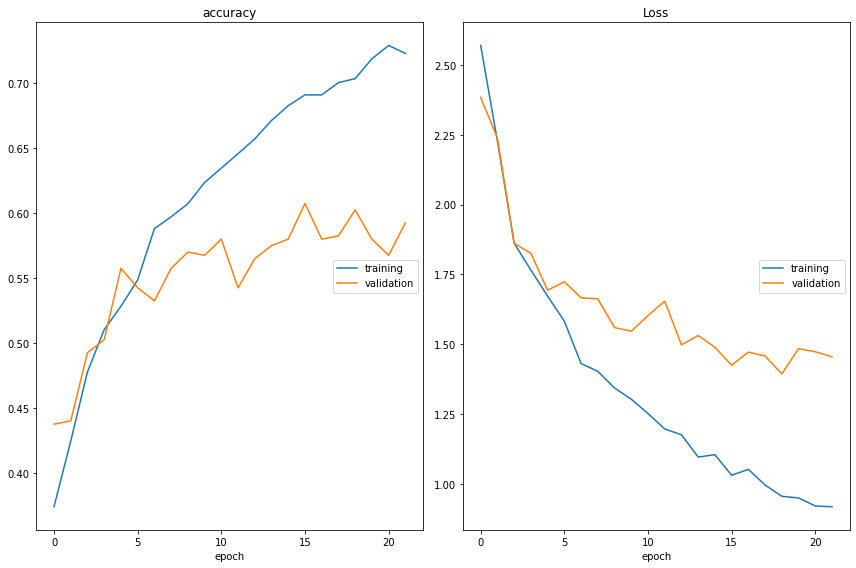

accuracy
	training         	 (min:    0.374, max:    0.729, cur:    0.723)
	validation       	 (min:    0.438, max:    0.608, cur:    0.592)
Loss
	training         	 (min:    0.918, max:    2.570, cur:    0.918)
	validation       	 (min:    1.394, max:    2.384, cur:    1.455)
Epoch 23/200
10/72 [===>..........................] - ETA: 18s - loss: 0.7834 - accuracy: 0.7540

KeyboardInterrupt: ignored

In [112]:
#fit the model
history = model.fit(train_dataloader, 
                    # steps_per_epoch=int(len(train_dataloader)//batch_size),
                    epochs=epochs,
                    callbacks=[PlotLossesKeras()],
                    validation_data = val_dataloader,
                    # validation_steps=int(len(val_dataloader)//batch_size),
                    )

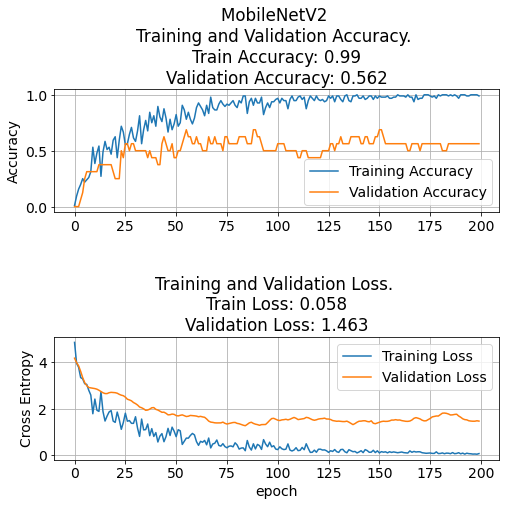

In [114]:
#get results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

#plot results
#accuracy
plt.figure(figsize=(8, 8))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'MobileNetV2 \nTraining and Validation Accuracy. \nTrain Accuracy: {str(round(acc[-1],3))}\nValidation Accuracy: {str(round(val_acc[-1],3))}')

#loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss: {str(round(loss[-1],3))}\nValidation Loss: {str(round(val_loss[-1],3))}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()